In [77]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import matplotlib.pyplot as plt

In [9]:
def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W


In [10]:
def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""
    res = 1.0 / (1.0 + np.exp(-1.0 * z))

    return res # your code here

In [75]:
def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Pick a reasonable size for validation data

    # ------------Initialize preprocess arrays----------------------#
    train_preprocess = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))
    # ------------Initialize flag variables----------------------#
    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0
    # ------------Start to split the data set into 6 arrays-----------#
    for key in mat:
        # -----------when the set is training set--------------------#
        if "train" in key:
            label = key[-1]  # record the corresponding label
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)  # get the length of current training set
            tag_len = tup_len - 1000  # defines the number of examples which will be added into the training set

            # ---------------------adding data to training set-------------------------#
            train_preprocess[train_len:train_len + tag_len] = tup[tup_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = label
            train_label_len += tag_len

            # ---------------------adding data to validation set-------------------------#
            validation_preprocess[validation_len:validation_len + 1000] = tup[tup_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = label
            validation_label_len += 1000

            # ---------------------adding data to test set-------------------------#
        elif "test" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            test_label_preprocess[test_len:test_len + tup_len] = label
            test_preprocess[test_len:test_len + tup_len] = tup[tup_perm]
            test_len += tup_len
            # ---------------------Shuffle,double and normalize-------------------------#
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data)
    train_data = train_data / 255.0
    train_label = train_label_preprocess[train_perm]

    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data)
    validation_data = validation_data / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data)
    test_data = test_data / 255.0
    test_label = test_label_preprocess[test_perm]

    # Feature selection
    # Your code here.
    # Check variance of each col
    varCol = np.var(train_data,axis=0)
    indxDel = list(*np.where(varCol<0.01))
    
    train_data = np.delete(train_data, indxDel, axis=1)
    validation_data = np.delete(validation_data, indxDel, axis=1)
    test_data = np.delete(test_data, indxDel, axis=1)
    

    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label

In [82]:
def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0

    # Your code here
    #
    #
    #
    #
    #
    dataLen = training_data.shape[0]
    
    # Forward propogation
    
    # Introducing bias
    inpDataB = np.c_[np.ones(len(training_data)),training_data]    
    
    # Equation 1: forward to hidden layer 1
    ly1Op=np.dot(x,np.transpose(w1)) 
    
    # Equation 2: Activation function for hidden layer 1
    l1Act = sigmoid(ly1Op)
    
    # Introducing bias for hidden layer
    l1Bias = np.c_[np.ones(len(l1Act)),l1Act]
    
    # Equation 3: Propogate to output layer
    opLy = np.dot(l1Bias,np.transpose(w2)) 

    # Equation 4: Activation function for output layer
    op = sigmoid(opLy)
    
    # Label transpose
    lbl = training_label.transpose()
    
    # Equation 5: Negative log likelyhood error ## Eq 6 & 7 combine
    
    nll = (-1/dataLen)*(np.sum(lbl*np.log(op) + (1-lbl) * np.log(1-op)))
    
    # Equation 8 & 9: Error delta & w2 Error
    delta = op - lbl
    
    w2Err = np.dot(delta,l1Act.transpose())
    
    # Equation 10, 11, 12: w1 Error
    
    w1Err = np.dot(((1- l1Act.transpose())* l1Act.transpose())* np.dot(delta,w2.transpose()),training_data.transpose)
    
    # Regularization
    
    # Equation 15: Regularization term 
 
    obj_val = nll + ((np.sum(w1**2) + np.sum(w2**2))/(2*dataLen))*lambdaval
    
    # Equation 16 & 17: Gradient
    
    w1Grad = (w1Err + lambdaval*w1)/dataLen
    w2Grad = (w2Err + lambdaval*w2)/dataLen

    


    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    obj_grad = np.array([])
    
    obj_grad = np.concatenate((w1Grad.flatten(),w2Grad.flatten()), axis = 0) 

    return (obj_val, obj_grad)

In [83]:
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""
    
    
    # Equation 1: forward to hidden layer 1
    ly1Op=np.dot(data,np.transpose(w1)) 
    
    # Equation 2: Activation function for hidden layer 1
    l1Act = sigmoid(ly1Op)
    
    # Equation 3: Propogate to output layer
    opLy = np.dot(l1Act,np.transpose(w2)) 

    # Equation 4: Activation function for output layer
    op = sigmoid(opLy)

    labels = np.argmax(op,axis=0)
    # Your code here

    return labels

In [14]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

preprocess done


In [78]:
"""**************Neural Network Script Starts here********************************"""

train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

#  Train Neural Network

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 50

# set the number of nodes in output unit
n_class = 10

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)

# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

# set the regularization hyper-parameter
lambdaval = 0

args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

# Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

opts = {'maxiter': 50}  # Preferred value.

nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

# In Case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
# and nnObjGradient. Check documentation for this function before you proceed.
# nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)


# Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))


preprocess done


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Test the computed parameters

predicted_label = nnPredict(w1, w2, train_data)

# find the accuracy on Training Dataset

print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

In [ ]:
predicted_label = nnPredict(w1, w2, validation_data)

# find the accuracy on Validation Dataset

print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')


In [ ]:
predicted_label = nnPredict(w1, w2, test_data)

# find the accuracy on Validation Dataset

print('\n Test set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')


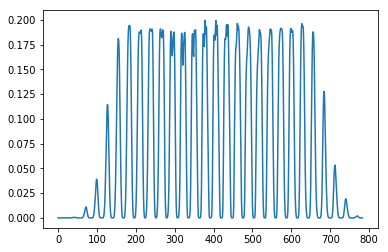

In [23]:
plt.plot(np.var(train_data,axis=0))

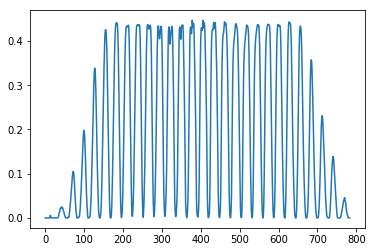

In [24]:
plt.plot(np.std(train_data,axis=0))

In [33]:
varCol = np.var(train_data,axis=0)
list(*np.where(varCol<0.01))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 389,
 390,
 391,
 392,
 39

In [49]:
x = np.c_[np.ones(len(train_data)),train_data]

In [71]:
y = train_label.astype(int) 

In [72]:
y=np.eye(10)[y]
y

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [73]:
set(train_label.astype(int) )

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [74]:
y[0].size

10

In [81]:
train_label.size

50000

In [95]:
import pandas as pd
import time

In [87]:
accDF = pd.DataFrame([[1,2,3,4,5,6]],columns = ['Nuerons','Lambda','TrainAcc','ValidAcc','TestAcc','ExeTime'])

In [89]:
accDF = accDF.append(accDF)

In [91]:
accDF = pd.DataFrame(columns = ['Nuerons','Lambda','TrainAcc','ValidAcc','TestAcc','ExeTime'])

In [92]:
accDF

,Nuerons,Lambda,TrainAcc,ValidAcc,TestAcc,ExeTime


In [99]:

startTime = time.time()

endTime = time.time()

exeTime = (endTime-startTime)
exeTime

1.8835067749023438e-05

In [100]:
mat = loadmat('mnist_all.mat')

In [101]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Nov 10 17:52:46 2005',
 '__version__': '1.0',
 'test0': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'test1': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'test2': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'test3': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],

In [102]:
import matplotlib.pyplot as plt

In [111]:
nnData = pd.read_csv('nnExecutionStats.txt',sep='\t')

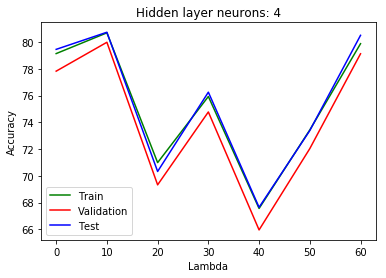

In [143]:
nrData = nnData[nnData['Neurons'] == 4]
lamb= list(nrData['Lambda'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Hidden layer neurons: " + str(4)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Lambda")
#plt.show()
plt.savefig('4.png')

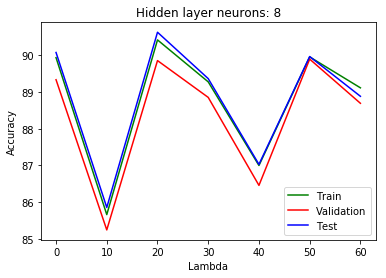

In [144]:

nrData = nnData[nnData['Neurons'] == 8]
lamb= list(nrData['Lambda'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Hidden layer neurons: " + str(8)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Lambda")
#plt.show()
plt.savefig('8.png')

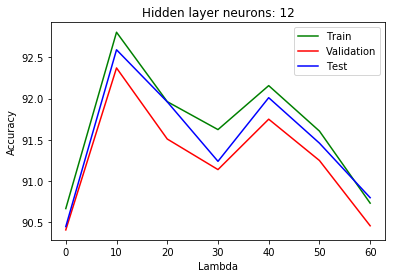

In [145]:

nrData = nnData[nnData['Neurons'] == 12]
lamb= list(nrData['Lambda'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Hidden layer neurons: " + str(12)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Lambda")
#plt.show()
plt.savefig('12.png')

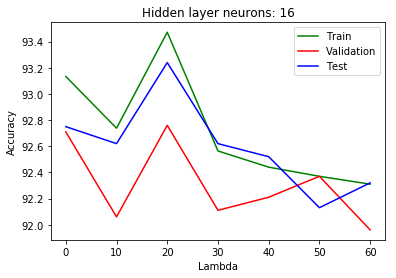

In [146]:

nrData = nnData[nnData['Neurons'] == 16]
lamb= list(nrData['Lambda'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Hidden layer neurons: " + str(16)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Lambda")
#plt.show()
plt.savefig('16.png')

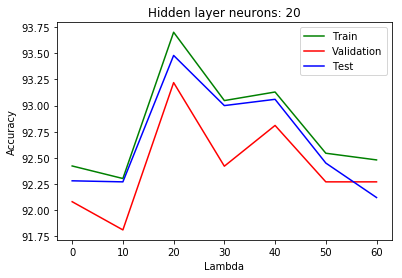

In [147]:

nrData = nnData[nnData['Neurons'] == 20]
lamb= list(nrData['Lambda'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Hidden layer neurons: " + str(20)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Lambda")
#plt.show()
plt.savefig('20.png')

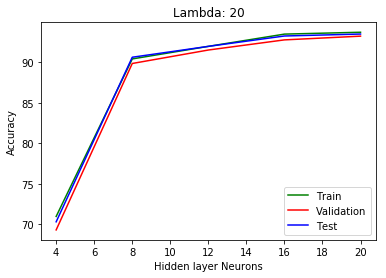

In [148]:

nrData = nnData[nnData['Lambda'] == 20]
lamb= list(nrData['Neurons'])
plt.plot(lamb,list(nrData['TrainAcc']),'g')
plt.plot(lamb,list(nrData['ValidAcc']),'r')
plt.plot(lamb,list(nrData['TestAcc']),'b')
plt.legend(['Train','Validation','Test'])
title = "Lambda: " + str(20)
plt.title(title)
plt.ylabel("Accuracy")
plt.xlabel("Hidden layer Neurons")
#plt.show()
plt.savefig('Lmb.png')

In [180]:
nnData

,Neurons,Lambda,TrainAcc,ValidAcc,TestAcc,ExeTime
0,4,0,79.144,77.83,79.46,36.735395
1,4,10,80.696,79.99,80.74,36.353194
2,4,20,70.992,69.33,70.33,33.438556
3,4,30,75.936,74.78,76.26,40.492816
4,4,40,67.564,65.96,67.65,33.417834
5,4,50,73.436,72.04,73.39,35.181007
6,4,60,79.884,79.13,80.51,41.771680
7,8,0,89.930,89.33,90.07,55.227985
8,8,10,85.666,85.25,85.86,53.286098
9,8,20,90.412,89.85,90.62,50.133207


In [179]:
maxIdx = nnData['ValidAcc'].argmax()
maxIdx

30

In [182]:
opParam = nnData.iloc[maxIdx]
opParam

Neurons     20.000000
Lambda      20.000000
TrainAcc    93.702000
ValidAcc    93.220000
TestAcc     93.480000
ExeTime     48.384475
Name: 30, dtype: float64

In [166]:
n_hidden = opParam["Neurons"]

20.0

In [168]:
lambdaval = opParam["Lambda"]

20.0

In [169]:
a = 10
b = 20
c = str(a) + str(b)
c

'1020'

In [170]:
import pickle

In [172]:
pickle_obj = pickle.load(file=open('params.pickle', 'rb'))

In [177]:
pickle_obj['feature']

TypeError: list indices must be integers or slices, not str